# 3.1 추론 기반 기법과 신경망

## 3.1.1 통계 기반 기법의 문제점
- 데이터가 커질수로 행렬이 너무나도 거대해짐
- SVD와 같은 방식은 한번에 처리해야해서 불가능해진다.
- sparse행렬이 생성됨.

## 3.1.2 추론 기반 기법 개요
- 단어의 분산표현을 얻는 방법 - 추론 기반 기법
- 똑같이 분포가설이 기반함.
- 맥락이 주어졌을 때 단어를 추론하는 방법. 
- 언어모델에 맥락이 주어졌을 때 단어의 확률을 얻을 수 있도록 설계

## 3.1.3 신경망에서의 단어 처리

In [2]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
h = np.matmul(c, W)
print(h)
print(W[0])

[[-0.11765    -1.04382071  1.08074704]]
[-0.11765    -1.04382071  1.08074704]


In [6]:
import sys
sys.path.append('../../modules/Part2/')
from common.layers import MatMul
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[ 0.66372822 -0.09635096  0.23406288]]


# 3.2 단순한 word2vec
- CBOW
- skip-gram

## 3.2.1 CBOW 모델의 추론 처리
- 맥락 -> 타깃
- 은닉층의 뉴런의 개수가 입력층보다 적은게 핵심
- 인코딩 , 함축적인 의미를 가짐 
- 디코딩 , 은닉층으로부터 원하는 결과를 얻음
- 입력층의 가중치 -> 분산표현. 부산물.

In [7]:
import sys
sys.path.append('../../modules/Part2/')
import numpy as np
from common.layers import MatMul

# sample data
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# Initail Weight
W_in = np.random.randn(7, 3) # 가중치를 공유한다는 것에 유의하기!!
W_out = np.random.randn(3, 7)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c0)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[-0.81540401  0.14998826 -1.19852937 -0.43011279 -0.20021707  0.04310549
   2.02094171]]


## 3.2.2 CBOW 모델의 학습
![fig 3-12.png](<attachment:fig 3-12.png>)
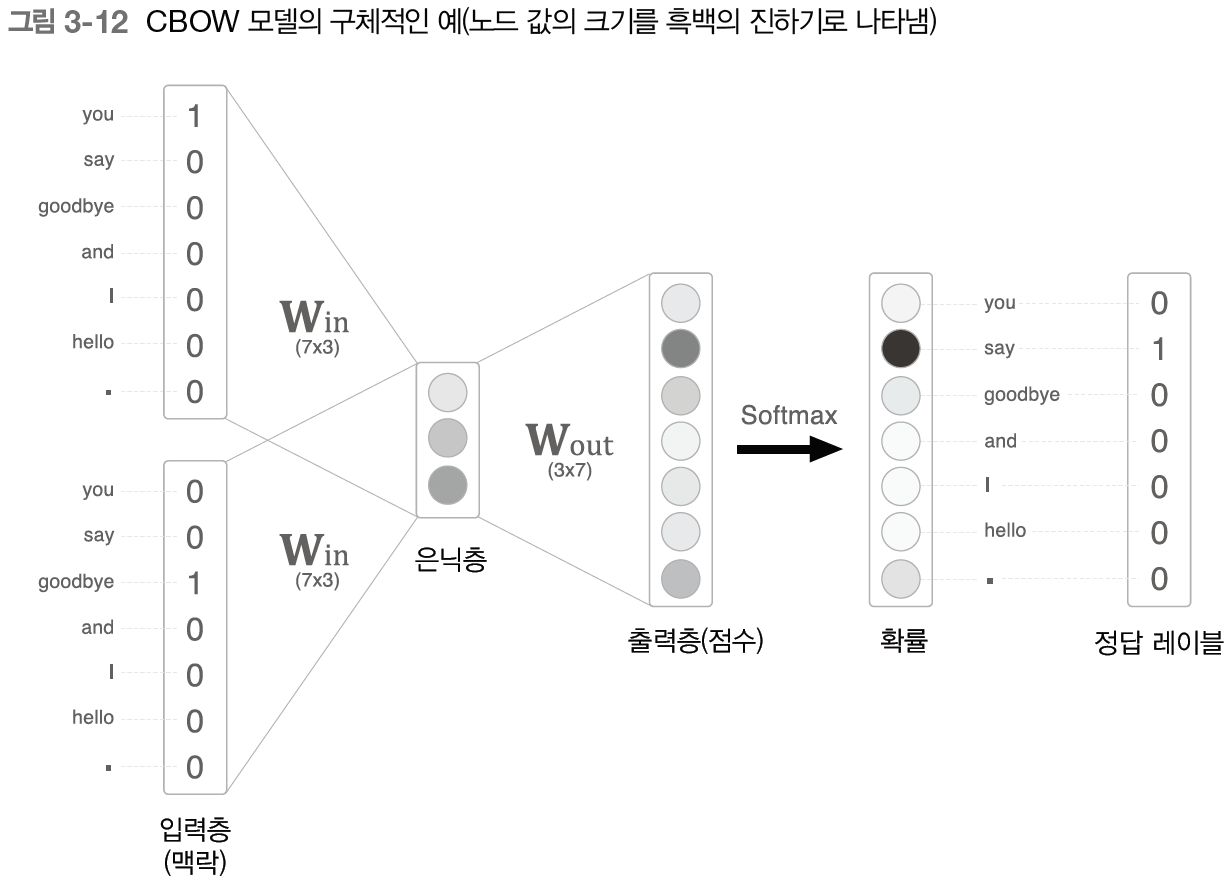

## 3.2.3 word2vec의 가중치와 분산표현
![fig 3-14.png](<attachment:fig 3-14.png>)
- word2vec(특히 skip-gram 모델)에서는 A 안인 '입력 측의 가중치만 이용한다'가 가장 대중적인 선택
- 한편 word2vec과 비슷한 기법인 GloVe에서는 두 가중치를 더했을 때 좋은 결과를 얻었다.
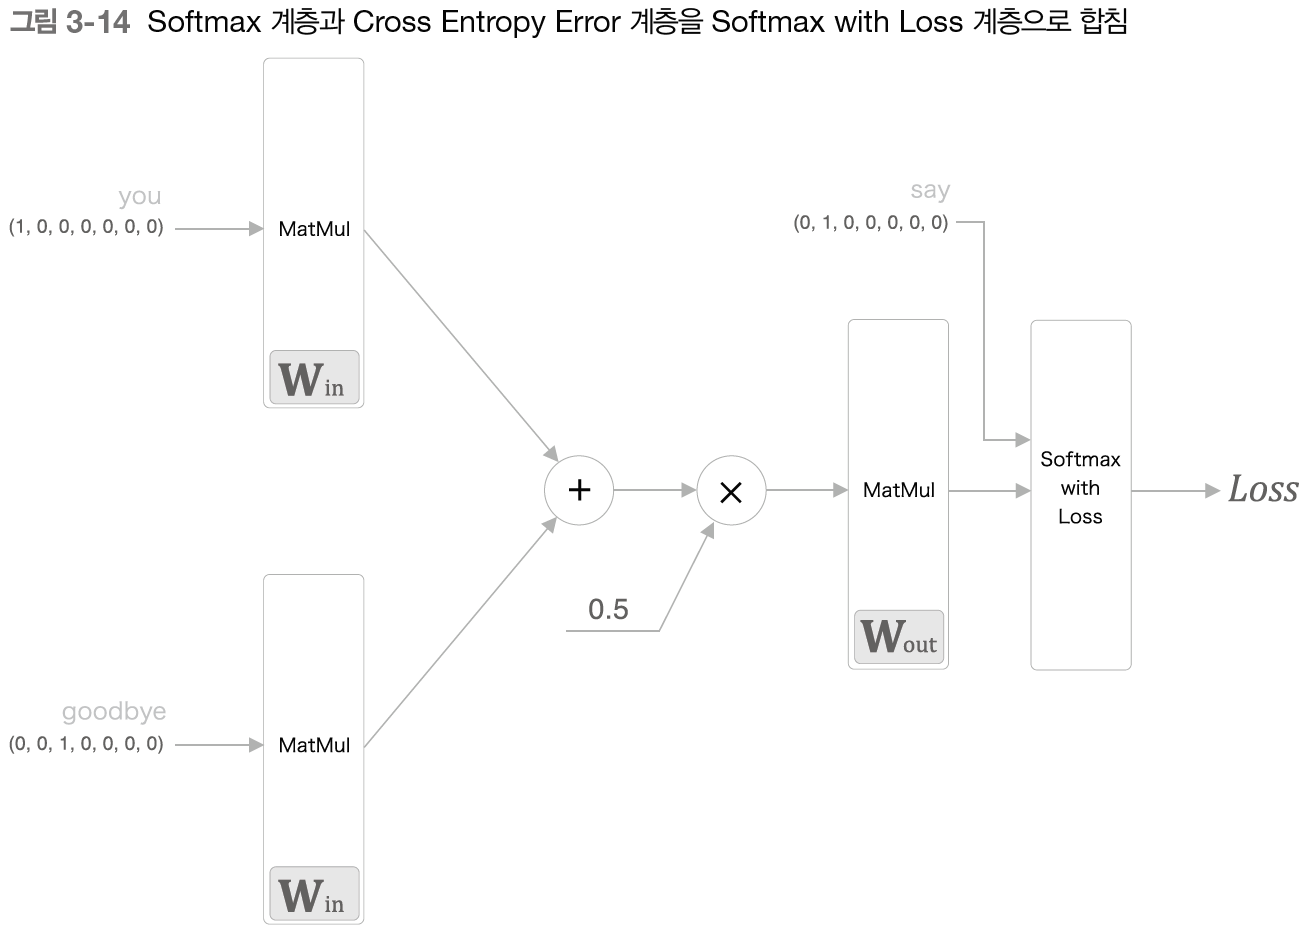

# 3.3 학습 데이터 준비

## 3.3.1 맥락과 타깃
- 신경망의 입력 : 맥락
- 맥락에 둘러싸인 중앙의 단어: 타깃 

In [1]:
import sys
sys.path.append('../../modules/Part2/')
import numpy as np
from common.utils import preprocess

In [2]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus, id_to_word)

[0 1 2 3 4 1 5 6] {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [3]:
def create_contexts_target(corpus, window_size=1):
  target = corpus[window_size:-window_size]
  contexts = []
  
  for idx in range(window_size, len(corpus)-window_size):
    cs = []
    for t in range(-window_size, window_size + 1):
      if t == 0:
        continue
      cs.append(corpus[idx + t])
    contexts.append(cs)
    
  return np.array(contexts), np.array(target)

In [5]:
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


## 3.2.2 원핫 표현으로 변환

In [1]:
import sys
sys.path.append('../../modules/Part2/')
import numpy as np
from common.utils import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [8]:
contexts.shape

(6, 2, 7)

In [6]:
target.shape

(6, 7)

# 3.4 CBOW 모델 구현

In [2]:
import os
os.listdir('../../modules/Part2/common/')

['base_model.py',
 'config.py',
 'functions.py',
 'layers.py',
 'np.py',
 'optimizer.py',
 'time_layers.py',
 'trainer.py',
 'util.py',
 '__init__.py']

In [1]:
import sys
sys.path.append('../../modules/Part2/')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

In [3]:
class SimpleCBOW:
  def __init__(self, vocab_size, hidden_size):
    V, H = vocab_size, hidden_size
    
    W_in = 0.01 * np.random.randn(V, H).astye('f')
    W_out = 0.01 * np.random.randn(V, H).astype('f')
    
    self.in_layer0 = MatMul(W_in)
    self.in_layer1 = MatMul(W_in)
    self.out_layer = MatMul(W_out)
    self.loss_layer = SoftmaxWithLoss()
    
    self.layers = [self.in_layer0, self.in_layer1, self.out_layer]
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
    
    self.word_vecs = W_in
    
  def forward(self, contexts, target):
    h = 0
    for i in range(len(self.layers) - 1):
      h += self.layers[i].forward(contexts[:, i])
    h *= 0.5
    
    score = self.out_layer.forward(h)
    loss = self.loss_layer.forward(score, target)
    
    return loss
  
  # gradient를 계산하는 과정. 아직 params 업데이트하기 전
  # grads는 self.grads로 전체 layer에 대한 grads를 관리함.
  def backward(self, dout=1): 
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(ds)
    da *= 0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    
    return None

## 3.4.1 학습코드 구현

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

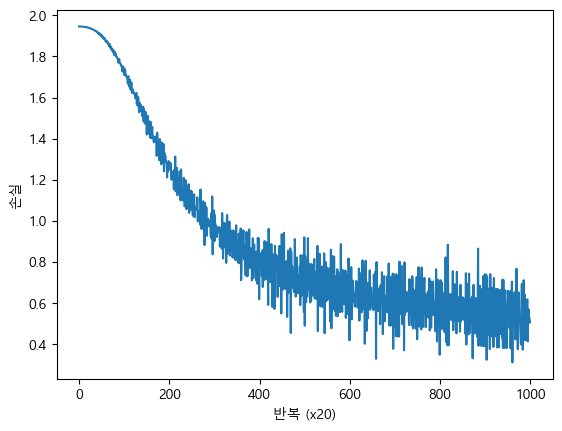

In [22]:
import sys
sys.path.append('../../modules/Part2/')
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic') # For Windows

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
contexts = convert_one_hot(contexts, vocab_size)
target = convert_one_hot(target, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()


In [23]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
  print(word, word_vecs[word_id])

you [ 1.2562746   1.2040664  -0.44277516  1.2221792   1.2973747 ]
say [-1.1934396  -1.1892607   1.2581304  -0.53903663 -0.09188647]
goodbye [ 0.6711512   0.7710278  -1.3512571   0.71360755  0.67656755]
and [-0.95830727 -0.9168688   1.1172391  -1.5132176  -1.590383  ]
i [ 0.68250245  0.7808233  -1.346762    0.7417804   0.68174976]
hello [ 1.249579   1.1982722 -0.4266495  1.2140658  1.2976168]
. [-1.0542569 -1.0867658  1.0841616  1.5391004  1.4716948]


# 3.5 word2vec 보충
- CBOW 모델을 '확률'관점에서 다시 살펴본다

## 3.5.1 CBOW 모델과 확률
- CBOW가 모델링하고 있는 것
- $P(w_t|w_{t-1}, w_{t+1})$
- $L=-logP(w_t|w_{t-1}, w_{t+1})$ (음의 로그 가능도, negative log likelihood)
- $L=-\frac{1}{T}\sum_{t=1}^T logP(w_t|w_{t-1}, w_{t+1})$

## 3.5.2 skip-gram 모델
- CBOW의 맥락과 타겟을 역전시킨 모델
- ![fig 3-23.png](<attachment:fig 3-23.png>)
- 중앙의 단어(타겟)으로 부터 주변의 여러 단어(맥락)를 추출
- ![fig 3-24.png](<attachment:fig 3-24.png>)
- 각 출력층에서 개별적으로 손실을 구하고 이 개별 손실들을 모두 더한 값을 최종 손실로 구함
- $P(w_{t-1}, w_{t+1}|w_t)$
- $P(w_{t-1}, w_{t+1}|w_t) = P(w_{t-1}|w_t) * P(w_{t+1}|w_t)$
  - 조건부 독립을 가정(맥락의 단어들 사이에 관련성이 없다고 가정)
- $L = -logP(w_{t-1}, w_{t+1}|w_t) = -logP(w_{t-1}|w_t) * P(w_{t+1}|w_t)$
- $L = -\frac{1}{T}\sum_{t=1}^T(logP(w_{t-1}|w_t)+ logP(w_{t+1}|w_t))$
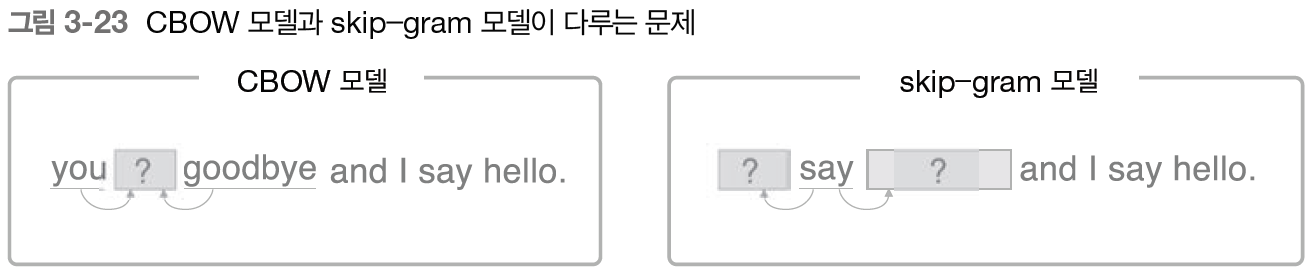
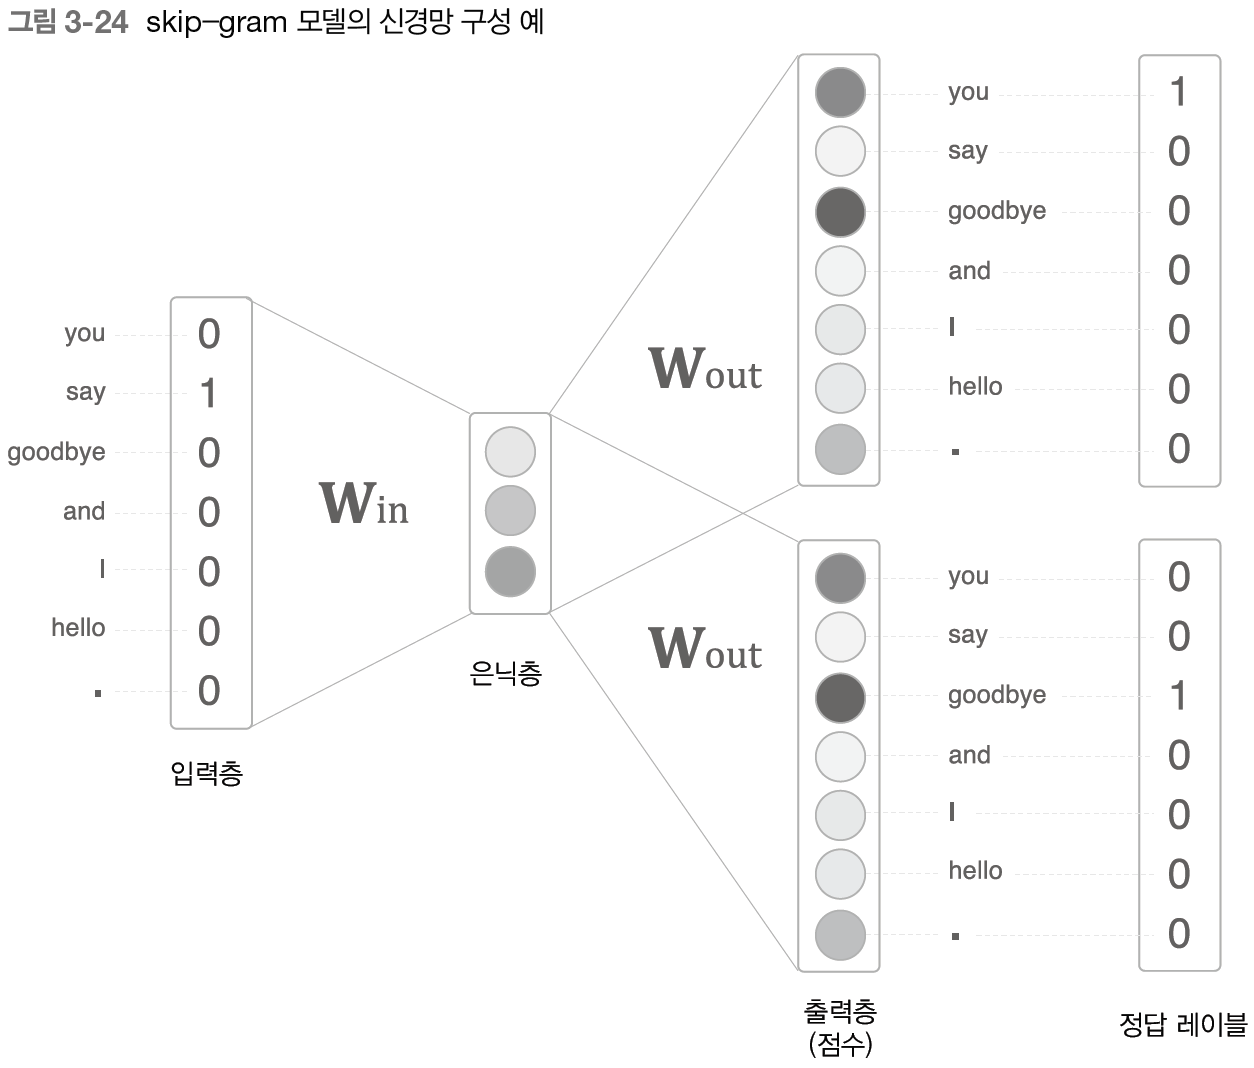

## CBOW vs skip-gram
- 어떤 것을 사용할까? -> skip-gram
  - 단어 분산 표현의 정밀도 면에서 skip-gram 모델의 결과가 더 좋은 경우가 많기 때문에
  - 말뭉치가 커질 수록 저빈도 단어나 유추 문제의 성능 면에서 skip-gram 모델이 더 뛰어난 경향이 있다.
  - 학습속도 CBOW > skip-gram. 손실을 맥락의 수만큼 구해야해서
- skip-gram이 더 어려운 문제를 푼다
  - 더 어려운 상황에서 단련하는 만큼 skip-gram 모델이 내어 주는 단어의 분산 표현이 더 뛰어날 가능성이 커진다.

## 3.5.3 통계기반 vs 추론기반
- 한번에 vs 조금씩 (미니배치)
- 전이학습이 가능, 새 단어가 생겨서 단어의 분산표현을 갱신해야하는 상황
- 단어의 유사성이 인코딩 됨 vs 유사성 + 복잡한 단어 사이의 패턴까지도 인코딩됨
  - king - man + woman = quenn. 유추문제를 풀 수 있음
- skip-gram + nagative sample == 동시발생 행렬 + SVD.
- 두 세계는 서로 연결되어 있다.
- Glove 